# IMport data

In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sid321axn/beijing-multisite-airquality-data-set")

print("Path to dataset files:", path)

c:\Users\marte\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\marte\.cache\kagglehub\datasets\sid321axn\beijing-multisite-airquality-data-set\versions\1


# Imports

In [14]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Exploratory Data analysis

hello world


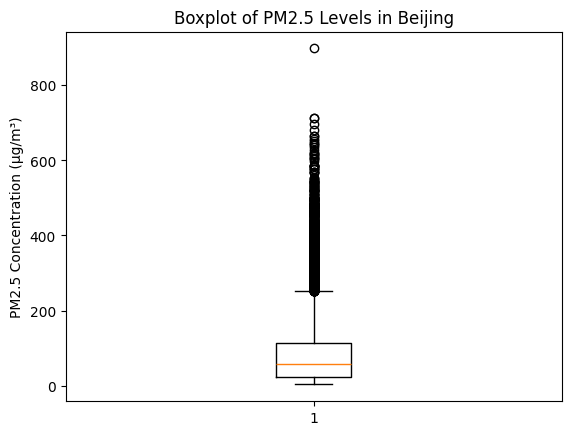

In [17]:
print("hello world")

df = pd.read_csv(os.path.join(path, "PRSA_Data_Aotizhongxin_20130301-20170228.csv"))
airpoll = df['PM2.5']
airpoll.describe()

# boxplot of PM2.5 levels
plt.boxplot(airpoll.dropna())
plt.title("Boxplot of PM2.5 Levels in Beijing")
plt.ylabel("PM2.5 Concentration (µg/m³)")
plt.show()